   Total service life time (hours)  Service and maintenance condition  \
0                     94464.049823                                  2   
1                     29400.484976                                  1   
2                     16883.400769                                  4   
3                    114155.143212                                  2   
4                     39184.604262                                  2   

   Type of blade  Maximum blade capacity (m³)  Blade sharpness  Ripper used?  \
0              3                          8.8                1             1   
1              3                         11.8                1             0   
2              3                          8.8                3             0   
3              3                         11.8                4             0   
4              4                         11.8                4             1   

   Time between gear shifting (seconds)  Operator’s skill  \
0                  

C:\Users\tugbe\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                                    feature           VIF
0                                     const  3.912311e+01
1           Total service life time (hours)  9.630047e+00
2    Number of consecutive operational days  9.230446e+00
3                          Ground grade (%)  9.593386e+00
4                       Dozing distance (m)  9.832816e+00
..                                      ...           ...
115         Ripper used?_1 Operation time_2  3.400843e+00
116         Ripper used?_1 Operation time_3  3.445503e+00
117                      Operation time_2^2  6.694120e+07
118       Operation time_2 Operation time_3           NaN
119                      Operation time_3^2  4.785519e+04

[120 rows x 2 columns]
Best parameters for Lasso: {'alpha': 0.01}
Initial Lasso Regression R²: 0.7171
Initial Lasso Regression MSE: 18.9008
Initial Lasso Regression CV R²: 0.7137 ± 0.0097
                                       OLS Regression Results                                      
Dep. Variable: 

                                       OLS Regression Results                                      
Dep. Variable:     Actual Measured Productivity (Lm³/Hour)   R-squared:                       0.723
Model:                                                 OLS   Adj. R-squared:                  0.721
Method:                                      Least Squares   F-statistic:                     398.2
Date:                                     Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                                             16:48:53   Log-Likelihood:                -11467.
No. Observations:                                     4000   AIC:                         2.299e+04
Df Residuals:                                         3973   BIC:                         2.316e+04
Df Model:                                               26                                         
Covariance Type:                                 nonrobust                                         


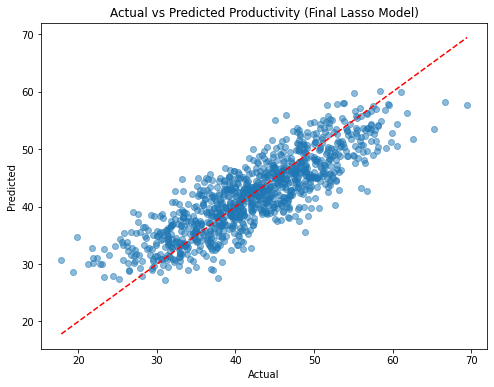

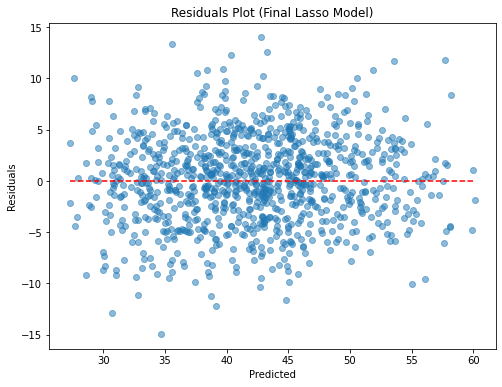

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from pyDOE2 import lhs

# Set random seed for reproducibility
np.random.seed(42)

# Define the ranges and probabilities for each feature
feature_ranges = {
    "Total service life time (hours)": (0, 150000),
    "Service and maintenance condition": ["Good", "Average", "Rather poor", "Poor"],
    "Type of blade": ["Straight tilt dozer", "U-tilt dozer", "Semi U-tilt dozer", "Angle dozer"],
    "Maximum blade capacity (m³)": [4.8, 6.8, 8.8, 11.8],
    "Blade sharpness": ["Good", "Average", "Rather poor", "Poor"],
    "Ripper used?": ["Yes", "No"],
    "Time between gear shifting (seconds)": ["Less than 5", "Between 5~10", "More than 10"],
    "Operator’s skill": ["Good", "Average", "Rather poor", "Poor"],
    "Overall operator’s condition during the operation": ["Good", "Average", "Rather poor", "Poor"],
    "Site management quality": ["Good", "Average", "Rather poor", "Poor"],
    "Number of consecutive operational days": (0, 100),
    "Predominant soil type": ["Sand", "Sandy clay", "Clay", "Gravel", "Broken rocks"],
    "Big pieces of rock exist on the site?": ["No", "Rarely", "Commonly"],
    "Equipment maneuvering space": ["Easy", "Average", "Rather difficult", "Difficult"],
    "Ground grade (%)": (-25, 25),
    "Dozing distance (m)": (0, 150),
    "Operation time": ["Morning", "Afternoon", "Night"],
    "Average temperature during operation (°C)": (-15, 45)
}

# Assign numerical values for categorical data
ordinal_mapping = {
    "Service and maintenance condition": {"Good": 4, "Average": 3, "Rather poor": 2, "Poor": 1},
    "Blade sharpness": {"Good": 4, "Average": 3, "Rather poor": 2, "Poor": 1},
    "Ripper used?": {"Yes": 1, "No": 0},
    "Time between gear shifting (seconds)": {"Less than 5": 3, "Between 5~10": 2, "More than 10": 1},
    "Operator’s skill": {"Good": 4, "Average": 3, "Rather poor": 2, "Poor": 1},
    "Overall operator’s condition during the operation": {"Good": 4, "Average": 3, "Rather poor": 2, "Poor": 1},
    "Site management quality": {"Good": 4, "Average": 3, "Rather poor": 2, "Poor": 1},
    "Predominant soil type": {"Sand": 1, "Sandy clay": 2, "Clay": 3, "Gravel": 4, "Broken rocks": 5},
    "Big pieces of rock exist on the site?": {"No": 1, "Rarely": 2, "Commonly": 3},
    "Equipment maneuvering space": {"Easy": 4, "Average": 3, "Rather difficult": 2, "Difficult": 1},
    "Operation time": {"Morning": 3, "Afternoon": 2, "Night": 1},
    "Type of blade": {"Straight tilt dozer": 1, "U-tilt dozer": 2, "Semi U-tilt dozer": 3, "Angle dozer": 4}
}

# Function to generate dataset using Latin Hypercube Sampling
def generate_lhs_dataset(n_samples):
    data = lhs(len(feature_ranges), samples=n_samples)
    df = pd.DataFrame(data, columns=feature_ranges.keys())

    for feature, value_range in feature_ranges.items():
        if isinstance(value_range, tuple):
            df[feature] = df[feature] * (value_range[1] - value_range[0]) + value_range[0]
        else:
            df[feature] = df[feature].apply(lambda x: np.random.choice(value_range))

    for feature, mapping in ordinal_mapping.items():
        df[feature] = df[feature].map(mapping)
    
    # Add noise to the equation
    def calculate_amp(row):
        noise = np.random.normal(0, 2)
        return (0.00001 * row["Total service life time (hours)"] +
                row["Service and maintenance condition"] +
                row["Type of blade"] +
                0.1 * row["Maximum blade capacity (m³)"] +
                row["Blade sharpness"] +
                10 * row["Ripper used?"] +
                row["Time between gear shifting (seconds)"] +
                row["Operator’s skill"] +
                row["Overall operator’s condition during the operation"] +
                row["Site management quality"] +
                0.01 * row["Number of consecutive operational days"] +
                row["Predominant soil type"] +
                row["Big pieces of rock exist on the site?"] +
                row["Equipment maneuvering space"] +
                0.01 * row["Ground grade (%)"] +
                0.1 * row["Dozing distance (m)"] +
                row["Operation time"] +
                0.1 * row["Average temperature during operation (°C)"] +
                noise)

    df["Actual Measured Productivity (Lm³/Hour)"] = df.apply(calculate_amp, axis=1)
    
    return df

# Generate the dataset
lhs_dataset = generate_lhs_dataset(5000)
print(lhs_dataset.head())

# Define the preprocessing steps
quantitative_columns = [
    "Total service life time (hours)", 
    "Number of consecutive operational days", 
    "Ground grade (%)", 
    "Dozing distance (m)", 
    "Average temperature during operation (°C)"
]

ordinal_columns = [
    "Service and maintenance condition", 
    "Blade sharpness", 
    "Time between gear shifting (seconds)", 
    "Operator’s skill", 
    "Overall operator’s condition during the operation", 
    "Site management quality", 
    "Predominant soil type", 
    "Big pieces of rock exist on the site?", 
    "Equipment maneuvering space"
]

nominal_columns = [
    "Type of blade", 
    "Maximum blade capacity (m³)", 
    "Ripper used?", 
    "Operation time"
]

# Preprocessing pipelines for quantitative and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

nominal_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, quantitative_columns),
        ('nom', nominal_transformer, nominal_columns)
    ])

# Apply preprocessing
X = lhs_dataset.drop(columns=['Actual Measured Productivity (Lm³/Hour)'])
y = lhs_dataset['Actual Measured Productivity (Lm³/Hour)']

# Transform features
X_preprocessed = preprocessor.fit_transform(X)

# Add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_preprocessed)

# Get feature names after preprocessing and polynomial transformation
numeric_features = preprocessor.transformers_[0][2]
nominal_features = preprocessor.transformers_[1][1].get_feature_names_out(nominal_columns)
all_features = np.concatenate([numeric_features, nominal_features])
poly_features = poly.get_feature_names_out(all_features)

# Convert to DataFrame
X_poly_df = pd.DataFrame(X_poly, columns=poly_features)

# Ensure data types are correct
X_poly_df = X_poly_df.apply(pd.to_numeric)

# Calculate VIF
X_poly_df_const = sm.add_constant(X_poly_df)  # Add constant term
vif_data = pd.DataFrame()
vif_data["feature"] = X_poly_df_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_poly_df_const.values, i) for i in range(len(X_poly_df_const.columns))]

print(vif_data)

# Drop features with high VIF (typically VIF > 10 indicates high multicollinearity), excluding 'const'
high_vif_features = vif_data[(vif_data["VIF"] > 10) & (vif_data["feature"] != "const")]["feature"].tolist()
X_poly_df_reduced = X_poly_df.drop(columns=high_vif_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_df_reduced, y, test_size=0.2, random_state=42)

# Train Lasso regression model with cross-validation to find the best alpha
lasso = Lasso(max_iter=100000)
param_grid = {
    'alpha': np.logspace(-4, 4, 9)  # Adjusted range
}
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

# Best alpha
best_params = lasso_cv.best_params_
print(f"Best parameters for Lasso: {best_params}")

# Train the initial Lasso regression model with the best parameters
initial_lasso_model = Lasso(alpha=best_params['alpha'], max_iter=100000)
initial_lasso_model.fit(X_train, y_train)

# Evaluate the initial model on the test set
initial_y_pred = initial_lasso_model.predict(X_test)
initial_r2 = r2_score(y_test, initial_y_pred)
initial_mse = mean_squared_error(y_test, initial_y_pred)
print(f"Initial Lasso Regression R²: {initial_r2:.4f}")
print(f"Initial Lasso Regression MSE: {initial_mse:.4f}")

# Perform cross-validation for the initial model
initial_cv_scores = cross_val_score(initial_lasso_model, X_train, y_train, cv=5, scoring='r2')
print(f"Initial Lasso Regression CV R²: {np.mean(initial_cv_scores):.4f} ± {np.std(initial_cv_scores):.4f}")

# Fit OLS model for p-value inspection
X_train_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

# Iteratively remove features with p-values > 0.05
while True:
    p_values = ols_model.pvalues
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        excluded_feature = p_values.idxmax()
        X_train_const = X_train_const.drop(columns=excluded_feature)
        X_train = X_train.drop(columns=excluded_feature)
        X_test = X_test.drop(columns=excluded_feature)
        ols_model = sm.OLS(y_train, X_train_const).fit()
    else:
        break

print(ols_model.summary())

# Train the final Lasso regression model
final_lasso_model = Lasso(alpha=best_params['alpha'], max_iter=100000)
final_lasso_model.fit(X_train, y_train)

# Evaluate the final model on the test set
final_y_pred = final_lasso_model.predict(X_test)
final_r2 = r2_score(y_test, final_y_pred)
final_mse = mean_squared_error(y_test, final_y_pred)
print(f"Final Lasso Regression R²: {final_r2:.4f}")
print(f"Final Lasso Regression MSE: {final_mse:.4f}")

# Perform cross-validation for the final model
final_cv_scores = cross_val_score(final_lasso_model, X_train, y_train, cv=5, scoring='r2')
print(f"Final Lasso Regression CV R²: {np.mean(final_cv_scores):.4f} ± {np.std(final_cv_scores):.4f}")

# Plot actual vs predicted for final model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Productivity (Final Lasso Model)')
plt.show()

# Plot residuals for final model
final_residuals = y_test - final_y_pred
plt.figure(figsize=(8, 6))
plt.scatter(final_y_pred, final_residuals, alpha=0.5)
plt.hlines(0, xmin=final_y_pred.min(), xmax=final_y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals Plot (Final Lasso Model)')
plt.show()
